In [1]:
%matplotlib inline
import gc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from h_gen import *
from keras import callbacks
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img, img_to_array, flip_axis, array_to_img
from keras.utils.layer_utils import layer_from_config
from tqdm import tqdm_notebook as tq
from heatmap import *
from keras.applications.xception import Xception


remote = callbacks.RemoteMonitor(root='http://localhost:9000')

Using Theano backend.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)


In [2]:
def change_resolution_25p_up(x):
    x = array_to_img(x)
    size = [int(a * 1.25) for a in x.size]
    x = scipy.misc.imresize(x, size[::-1], interp='bilinear', mode=None)
    return img_to_array(x)


def change_resolution_25p_down(x):
    x = array_to_img(x)
    size = [int(a * 0.75) for a in x.size]
    x = scipy.misc.imresize(x, size[::-1], interp='bilinear', mode=None)
    return img_to_array(x)


def flip_horizontal_img(x):
    return flip_axis(x, 2)
def flip_horizontal_hm(x):
    return flip_axis(x, 1)


def flip_vertical_img(x):
    return flip_axis(x, 1)
def flip_vertical_hm(x):
    return flip_axis(x, 0)


def rotate_img_15_up(x):
    x = array_to_img(x)
    x = x.rotate(15)
    return img_to_array(x)
def rotate_hm_15_down(x):
    x = array_to_img(np.expand_dims(x, axis=0))
    x = x.rotate(-15)
    return img_to_array(x)[0] / 255

In [3]:
def generate_heatmaps(models, models_names,transformations, inverses, transformations_names):
    mk("heatmaps")
    mk("heatmaps/pickle")
    mk("heatmaps/png")
    
    paths_list = get_all_images()
    
    for model_function, model_name in zip(models, models_names):
        model = model_function()
        model = to_heatmap(model)
        
        mk("heatmaps/pickle/" + model_name)
        mk("heatmaps/png/" + model_name)
        
        
        for path in tq(paths_list):
        
            for transformation, inverse, tr_name in zip(transformations, inverses, transformations_names):
            
                mk("heatmaps/pickle/" + model_name + "/" + tr_name)
                mk("heatmaps/png/" + model_name + "/" + tr_name)
                mk("heatmaps/png/" + model_name + "/" + tr_name +"/"+ path[7:].split("/")[1])
                mk("heatmaps/pickle/" + model_name + "/" + tr_name +"/"+ path[7:].split("/")[1])
                
                pickle_path = "heatmaps/pickle/" + model_name + "/" + tr_name +  path[7:]
                png_path = "heatmaps/png/" + model_name + "/" + tr_name +  path[7:]
                
                if "eption" in model_name:
                    inception=True
                else:
                    inception=False
                
                #if not os.path.isfile(pickle_path) or not os.path.isfile(png_path):
                if True:
                    img = load_img(path)
                    img = img_to_array(img)
                    h = get_heatmap_from_transformation(img, model, transformation, inverse, debug=True, inception=inception)
                    assert False
                    #print(np.max(h))
                    with open(pickle_path, "wb") as f:
                        pickle.dump(h, f, protocol=pickle.HIGHEST_PROTOCOL)
                    
                    h=h*255
                    plt.imsave(png_path,h)

In [3]:
def get_heatmap(model_conv, img_path, transformations, inverses,  debug=False):
    img = load_img(img_path)
    img = img_to_array(img)
    result = None
    
    for transformation, inverse in zip(transformations, inverses):
        h = get_heatmap_from_transformation(img, model_conv, transformation, inverse, debug=debug)
        if result is None:
            result = h
        else:
            result += h
            
    return result

In [8]:
model_conv1 = to_heatmap(VGG16())
model_conv = Model(model_conv1.input, model_conv1.layers[-2].output)

Model type detected: local pooling - flatten

Model cut at layer: 18

Pool size infered: 7

In [8]:
model_conv.summary()

____________________________________________________________________________________________________

Layer (type)                     Output Shape          Param #     Connected to                     

input_6 (InputLayer)             (None, 3, None, None) 0                                            

____________________________________________________________________________________________________

model_9 (Model)                  multiple              14714688    input_6[0][0]                    

____________________________________________________________________________________________________

block5_pool (MaxPooling2D)       (None, 512, None, Non 0           model_9[1][0]                    

____________________________________________________________________________________________________

atrousconvolution2d_3 (AtrousCon (None, 4096, None, No 102764544   block5_pool[0][0]                

____________________________________________________________________________________________________

fc2 (Convolution2D)              (None, 4096, None, No 16781312    atrousconvolution2d_3[0][0]      

____________________________________________________________________________________________________

predictions (Convolution2D)      (None, 1000, None, No 4097000     fc2[0][0]                        

Total params: 138,357,544

Trainable params: 138,357,544

Non-trainable params: 0

____________________________________________________________________________________________________

In [9]:
models=[ VGG16, VGG19, ResNet50, InceptionV3][::-1]
models_names = ["VGG16","VGG19", "ResNet50", "InceptionV3"][::-1]
transformations = [lambda x:x, 
                   flip_horizontal_img,
                   flip_vertical_img,
                   rotate_img_15_up,
                   change_resolution_25p_up,
                   change_resolution_25p_down]

inverses = [lambda x:x, 
            flip_horizontal_hm,
            flip_vertical_hm,
            rotate_hm_15_down,
            lambda x: x,
            lambda x: x]

transformations_names = ["identity", 
                         "horizontal flip",
                         "vertical flip",
                         "rotate 15",
                         "resolution 25 up",
                         "resolution 25 down"]

(3, 720, 1280)

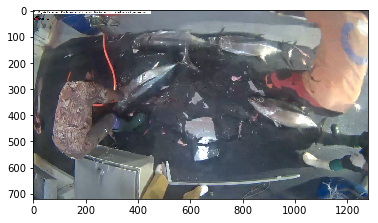

(3, 720, 1280)

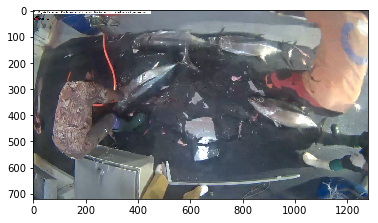

(1, 1000, 32, 67)

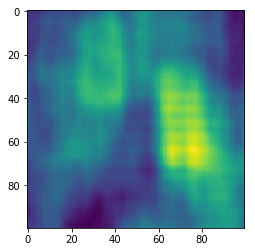

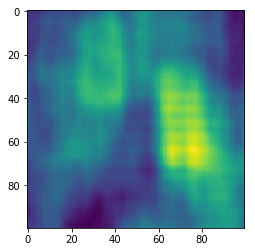

(3, 720, 1280)

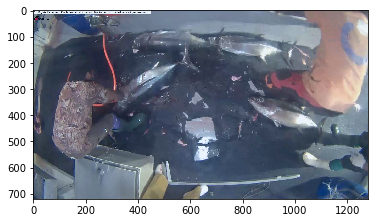

(3, 720, 1280)

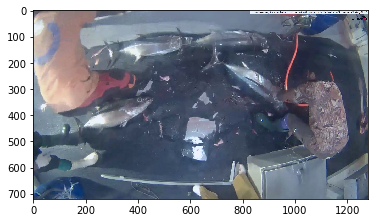

(1, 1000, 32, 67)

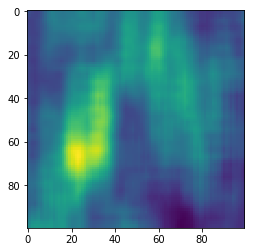

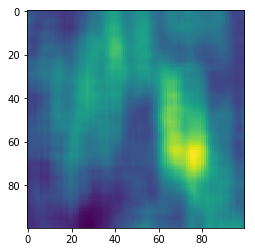

(3, 720, 1280)

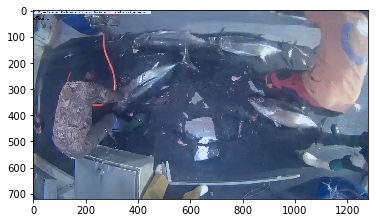

(3, 720, 1280)

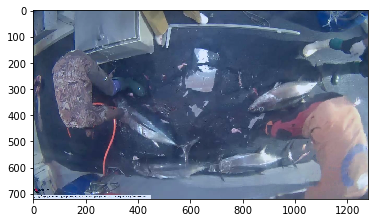

(1, 1000, 32, 67)

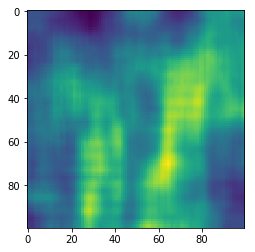

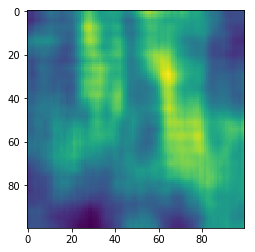

(3, 720, 1280)

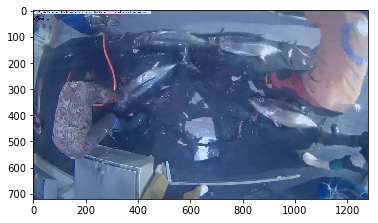

(3, 720, 1280)

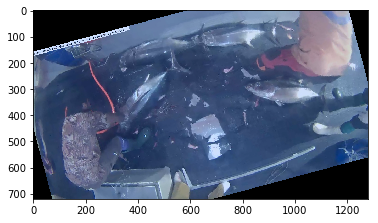

(1, 1000, 32, 67)

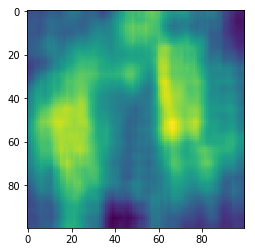

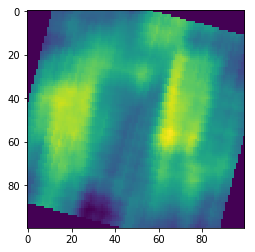

(3, 720, 1280)

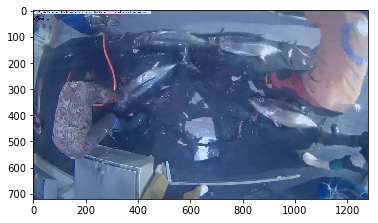

(3, 900, 1600)

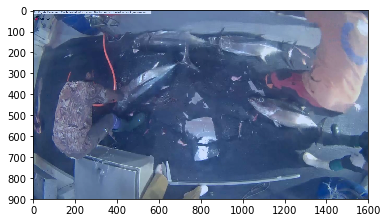

(1, 1000, 43, 87)

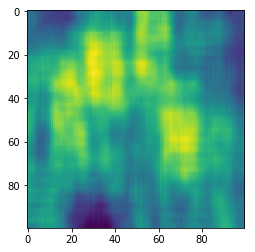

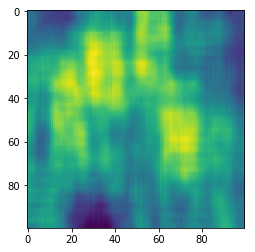

(3, 720, 1280)

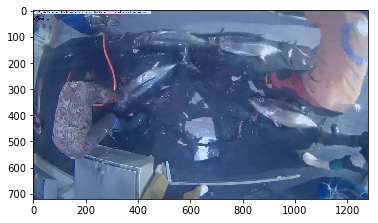

(3, 540, 960)

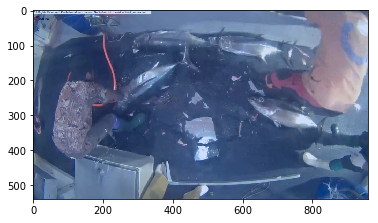

(1, 1000, 20, 47)

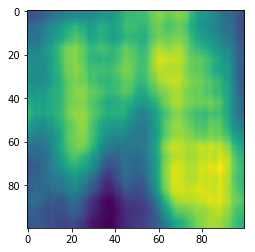

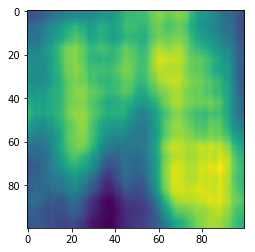

array([[ 1.23529412,  1.19215686,  1.15686275, ...,  1.        ,
         1.01960784,  1.08627451],
       [ 1.23529412,  1.19607843,  1.16078431, ...,  1.        ,
         1.01960784,  1.08235294],
       [ 1.23921569,  1.21176471,  1.18431373, ...,  0.99607843,
         1.        ,  1.05098039],
       ..., 
       [ 1.33333333,  1.33333333,  1.36470588, ...,  2.55294118,
         2.47058824,  2.43921569],
       [ 1.30980392,  1.30196078,  1.31764706, ...,  2.6       ,
         2.51372549,  2.49803922],
       [ 1.29019608,  1.28627451,  1.29803922, ...,  2.60392157,
         2.51764706,  2.50196078]])

In [11]:
get_heatmap(model_conv,"./train/ALB/img_00003.jpg",transformations,inverses,debug=True)

Model type detected: local pooling - flatten
Model cut at layer: 217
yolo
Pool size infered: 1
New convolution size: 1
(1, 1, 2048, 1000)
(2048, 1000)
[1, 1]
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
model_1 (Model)                  multiple              21611968    input_2[0][0]                    
____________________________________________________________________________________________________
avg_pool (AveragePooling2D)      (None, None, None, 20 0           model_1[1][0]                    
____________________________________________________________________________________________________
predictions (Convolution2D)      (

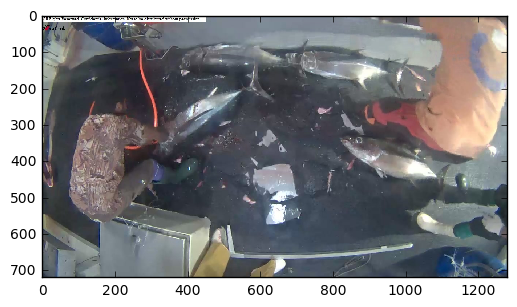

(720, 1280, 3)


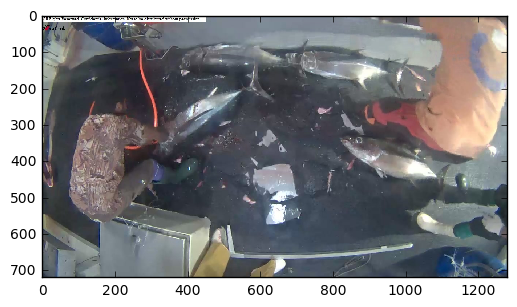

(1, 14, 31, 1000)


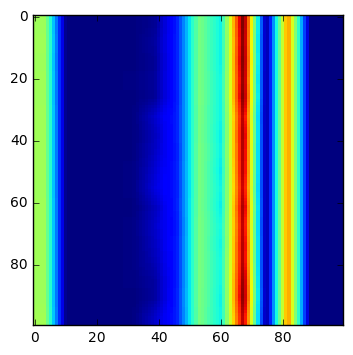

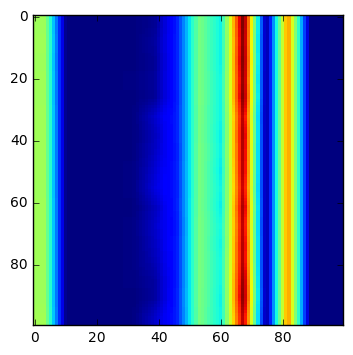

AssertionError: 

In [6]:
generate_heatmaps(models, models_names,transformations, inverses, transformations_names)

In [ ]:
img_path = "./train/ALB/img_00029.jpg"
img = image.load_img(img_path)
img = image.img_to_array(img)
with open("heatmaps/pickle/VGG16/horizontal flip/ALB/img_00029.jpg", "rb") as f:
    heatmap=pickle.load(f)

In [ ]:
i=4
test_transform(img, heatmap, transformations[i], inverses[i])

In [2]:
old_model = ResNet50()

In [10]:
old_model = VGG16()

In [3]:
model = to_heatmap(old_model)

Model type detected: local pooling - flatten
Model cut at layer: 174
yolo
Pool size infered: 1
New convolution size: 1
[1, 1]
twat
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
model_1 (Model)                  multiple              23587712    input_2[0][0]                    
____________________________________________________________________________________________________
avg_pool (AveragePooling2D)      (None, None, None, 20 0           model_1[1][0]                    
____________________________________________________________________________________________________
fc1000 (Convolution2D)           (None, None, None, 10 204900

In [4]:
print(model.layers[1].inbound_nodes[0].get_config())

{'node_indices': [], 'outbound_layer': 'model_1', 'tensor_indices': [], 'inbound_layers': []}


In [10]:
model.layers[1].get_input_at(0)

<tf.Tensor 'input_2:0' shape=(?, ?, ?, 3) dtype=float32>

In [15]:
for layer in model.layers:
    layer.trainable = False

In [8]:
model.layers[1].outbound_nodes

In [9]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, None, None, 20 23587712                                     
____________________________________________________________________________________________________
avg_pool (AveragePooling2D)      (None, None, None, 20 0           model_1[1][0]                    
____________________________________________________________________________________________________
fc1000 (Convolution2D)           (None, None, None, 10 2049000     avg_pool[0][0]                   
___________________________________________________________________________________________

In [17]:
img = image.load_img("train/ALB/img_00003.jpg")
img = image.img_to_array(img)

(1, 17, 34, 1000)
(17, 17, 34)


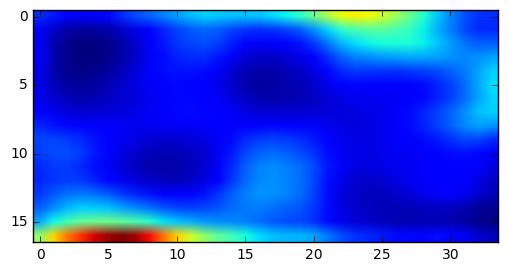

In [18]:
heatmap_transformed = get_heatmaps(img, model)
plt.imshow(heatmap_transformed)

(1, 1000, 17, 34)


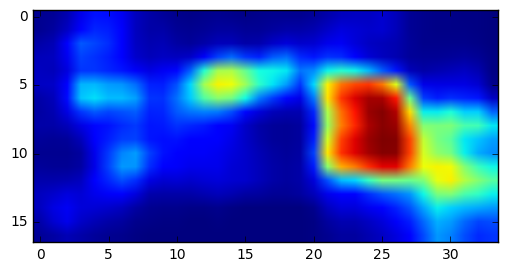

In [5]:
heatmap_transformed = get_heatmaps(img, model)
plt.imshow(heatmap_transformed)

insert_zeros=1
[[  1.97458430e-05   0.00000000e+00  -5.35124633e-03   0.00000000e+00
    6.60625810e-04   0.00000000e+00   1.47064368e-03   0.00000000e+00
   -6.35401171e-04   0.00000000e+00  -9.03767359e-04   0.00000000e+00
   -2.42536218e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]
(1, 32, 67, 1000)


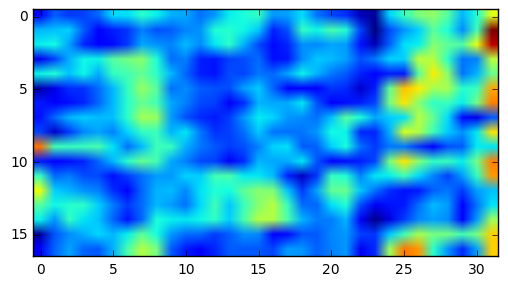

In [33]:
def insert_weights_2(layer, new_layer):
    W,b = layer.get_weights()
    if K.image_dim_ordering() == 'th':
        n_filter,previous_filter,ax1,ax2 = new_layer.get_weights()[0].shape
        ax1 = ax2 = int(np.sqrt(layer.get_weights()[0].shape[0]/new_layer.get_weights()[0].shape[1]))
        new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
        new_W = new_W.transpose((3,0,1,2))
        new_W = new_W[:,:,::-1,::-1]
    else:
        ax1,ax2, previous_filter, n_filter = new_layer.get_weights()[0].shape
        ax1 = ax2 = int(np.sqrt(layer.get_weights()[0].shape[0]/new_layer.get_weights()[0].shape[2]))
        r = [previous_filter,ax1,ax2,n_filter]
        new_W = W.reshape(r)
        new_W = new_W.transpose((1,2,0,3))
        #new_W = new_W[::-1,::-1,:,:]
    
    if ax1!=1:
        if K.image_dim_ordering() == 'th':
            insert_zeros = int((new_layer.get_weights()[0].shape[2] - ax1)/(ax1-1))
        else:
            insert_zeros = int((new_layer.get_weights()[0].shape[1] - ax1)/(ax1-1))
        print("insert_zeros=" + str(insert_zeros))
        new_W =  add_zeros(new_W, insert_zeros)
        print(new_W[:2,:,0,0])
    
    new_layer.set_weights([new_W,b])
    
for i in range(1,4):
    insert_weights_2(old_model.layers[-i], model.layers[-(i+1)])
heatmap_transformed = get_heatmaps(img, model)
plt.imshow(heatmap_transformed)

In [24]:
model.layers[133]

In [43]:
def insert_weights_2(weights, new_layer):
    W = weights[0]
    b = weights[1]

    if K.image_dim_ordering() == 'th':
        n_filter,previous_filter,ax1,ax2 = new_layer.get_weights()[0].shape
        ax1 = ax2 = int(np.sqrt(layer.get_weights()[0].shape[0]/new_layer.get_weights()[0].shape[1]))
        new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
        new_W = new_W.transpose((3,0,1,2))
        new_W = new_W[:,:,::-1,::-1]
    else:
        ax1,ax2, previous_filter, n_filter = new_layer.get_weights()[0].shape
        ax1 = ax2 = int(np.sqrt(layer.get_weights()[0].shape[0]/new_layer.get_weights()[0].shape[2]))
        r = np.array([ax1,ax2,previous_filter,n_filter])
        new_W = K.reshape(W,r)
        #new_W = new_W.transpose((1,2,0,3))
        #new_W = new_W[::-1,::-1,:,:]
    
    if ax1!=1:
        if K.image_dim_ordering() == 'th':
            insert_zeros = int((new_layer.get_weights()[0].shape[2] - ax1)/(ax1-1))
        else:
            insert_zeros = int((new_layer.get_weights()[0].shape[1] - ax1)/(ax1-1))
        print("insert_zeros=" + str(insert_zeros))
        new_W =  add_zeros(new_W, insert_zeros)
        print(new_W[:2,:,0,0])
    
    new_layer.set_weights([new_W,b])
    
insert_weights_2(load(133), model.layers[133])
heatmap_transformed = get_heatmaps(img, model)
plt.imshow(heatmap_transformed)

AttributeError: 'Tensor' object has no attribute 'shape'

In [5]:
with open("w_1.p","rb") as f:
    w_1 = pickle.load(f)
with open("w_2.p","rb") as f:
    w_2 = pickle.load(f)

In [7]:
w_1

array([[-0.01490746,  0.0113374 , -0.05073728, ..., -0.02179668,
        -0.07764222,  0.01018347],
       [-0.00294467,  0.00319835,  0.01953556, ...,  0.03623696,
         0.00350259, -0.03321117],
       [-0.01751374,  0.00807406,  0.00851311, ..., -0.03024036,
         0.05494978, -0.02511911],
       ..., 
       [ 0.025289  ,  0.0630148 ,  0.02041481, ..., -0.00508354,
        -0.03542514, -0.01306196],
       [-0.00623157, -0.01624131, -0.01221174, ...,  0.01376359,
         0.04087579, -0.0185826 ],
       [-0.02668471,  0.0130982 , -0.01847764, ...,  0.06304929,
         0.02561448, -0.00693536]], dtype=float32)

In [17]:
gc.collect()

0

In [1]:
from keras.utils.np_utils import convert_kernel
def flip_vertical_img(x):
    return flip_axis(x, 0)
def insert_weights_2(weights, new_layer):
    W = weights[0]
    b = weights[1]
    
    if K.image_dim_ordering() == 'th':
        n_filter,previous_filter,ax1,ax2 = new_layer.get_weights()[0].shape
        ax1 = ax2 = int(np.sqrt(W.shape[0]/new_layer.get_weights()[0].shape[1]))
        new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
        new_W = new_W.transpose((3,0,1,2))
        new_W = new_W[:,:,::-1,::-1]
    else:
        W = W[:,:]
        ax1,ax2, previous_filter, n_filter = new_layer.get_weights()[0].shape
        ax1 = ax2 = int(np.sqrt(W.shape[0]/new_layer.get_weights()[0].shape[2]))
        new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
        new_W = new_W.transpose((3,0,1,2))
        new_W = new_W[:,:,::-1,::-1]
        
    print([ax1, ax2])
    
    
    
    if ax1!=1:
        if K.image_dim_ordering() == 'th':
            insert_zeros = int((new_layer.get_weights()[0].shape[2] - ax1)/(ax1-1))
        else:
            insert_zeros = int((new_layer.get_weights()[0].shape[1] - ax1)/(ax1-1))
        print("insert_zeros=" + str(insert_zeros))
        new_W =  add_zeros(new_W, insert_zeros)
        print(new_W[:2,:,0,0])
        
    if K.image_dim_ordering() == 'tf':
        print("twat")
        
        new_W = np.swapaxes(new_W, 0, 3)
        new_W = np.swapaxes(new_W, 1, 2)
        #new_W = np.swapaxes(new_W, 0, 1)
        
        new_W = convert_kernel(new_W)
        
        
    
    new_layer.set_weights([new_W,b])
    
img = image.load_img("train/ALB/img_00055.jpg")
img = image.img_to_array(img)
insert_weights_2(load(133), model.layers[133])
img = flip_vertical_img(img)
heatmap_transformed = get_heatmaps(img, model, inception=True)
heatmap_transformed = flip_vertical_hm(heatmap_transformed)
plt.imshow(heatmap_transformed, interpolation="None")
plt.show()

Using TensorFlow backend.


NameError: name 'image' is not defined

In [18]:
img

array([[[ 255.,  254.,  250.],
        [ 253.,  253.,  251.],
        [ 253.,  255.,  254.],
        ..., 
        [ 101.,   96.,   92.],
        [ 100.,   95.,   91.],
        [ 100.,   95.,   91.]],

       [[ 254.,  255.,  253.],
        [ 254.,  254.,  252.],
        [ 255.,  255.,  255.],
        ..., 
        [  99.,   94.,   90.],
        [ 101.,   96.,   92.],
        [ 100.,   95.,   91.]],

       [[ 249.,  255.,  255.],
        [ 252.,  254.,  253.],
        [ 254.,  254.,  254.],
        ..., 
        [  98.,   93.,   89.],
        [  99.,   94.,   90.],
        [ 100.,   95.,   91.]],

       ..., 
       [[  45.,   55.,   67.],
        [  46.,   56.,   68.],
        [  46.,   56.,   68.],
        ..., 
        [  55.,   61.,   83.],
        [  55.,   61.,   83.],
        [  55.,   61.,   85.]],

       [[  45.,   55.,   67.],
        [  46.,   56.,   68.],
        [  46.,   56.,   68.],
        ..., 
        [  61.,   67.,   91.],
        [  62.,   68.,   94.],
        [ 

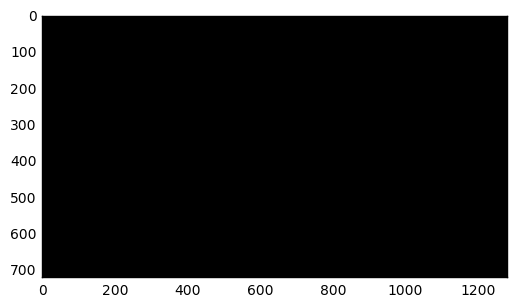

In [15]:
plt.imshow(array_to_img(img))

In [2]:
old_model = Xception()

In [3]:
W = old_model.layers[-1].get_weights()[0]

In [4]:
with open("xception_w", "wb") as f:
    pickle.dump(W,f)

In [5]:
with open("xception_w", "rb") as f:
    w = pickle.load(f)

In [18]:
model = Xception(include_top=False)

In [19]:
old_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 149, 149, 32)  864         input_3[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [5]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, None, None, 32 864         input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, None, None, 32 128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, None, None, 32 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [6]:
x = Convolution2D(1000,1,1)(x)

In [7]:
predictions = Softmax4D(axis=1,name="softmax")(x)

In [8]:
new_model = Model(input=model.input, output=predictions)

(2048, 1000)
(1000, 2048, 1, 1)
[1, 1]
twat
(1, 22, 39, 1000)
(17, 22, 39)


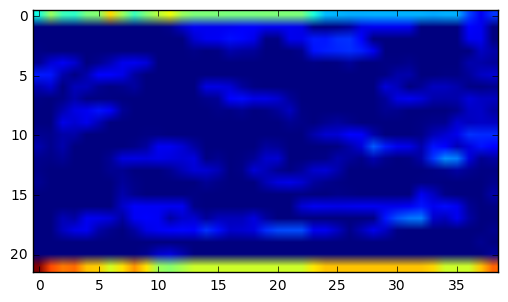

In [14]:
from keras.utils.np_utils import convert_kernel

def insert_weights2(layer, new_layer):
    W,b = layer.get_weights()
    print(W.shape)
    
    if K.image_dim_ordering() == 'th':
        n_filter,previous_filter,ax1,ax2 = new_layer.get_weights()[0].shape
        ax1 = ax2 = int(np.sqrt(layer.get_weights()[0].shape[0]/new_layer.get_weights()[0].shape[1]))
        new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
        new_W = new_W.transpose((3,0,1,2))
        new_W = new_W[:,:,::-1,::-1]
        with open("w_2.p","wb") as f:
            pickle.dump(new_W,f)
    else:
        W = W[:,:]
        ax1,ax2, previous_filter, n_filter = new_layer.get_weights()[0].shape
        ax1 = ax2 = int(np.sqrt(layer.get_weights()[0].shape[0]/new_layer.get_weights()[0].shape[2]))
        new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
        new_W = new_W.transpose((3,0,1,2))
        new_W = new_W[:,:,::-1,::-1]
        print(new_W.shape)
        
    print([ax1, ax2])
    
    
    
    if ax1!=1:
        if K.image_dim_ordering() == 'th':
            insert_zeros = int((new_layer.get_weights()[0].shape[2] - ax1)/(ax1-1))
        else:
            insert_zeros = int((new_layer.get_weights()[0].shape[1] - ax1)/(ax1-1))
        print("insert_zeros=" + str(insert_zeros))
        new_W =  add_zeros(new_W, insert_zeros)
        print(new_W[:2,:,0,0])
        
    if K.image_dim_ordering() == 'tf':
        print("twat")
        
        new_W = np.swapaxes(new_W, 0, 3)
        new_W = np.swapaxes(new_W, 1, 2)
        #new_W = np.swapaxes(new_W, 0, 1)
        
        new_W = convert_kernel(new_W)
        
        
    
    new_layer.set_weights([new_W,b])
    
for i in range(1,2):
    insert_weights2(old_model.layers[-i], new_model.layers[-(i+1)])
heatmap_transformed = get_heatmaps(img, new_model)
plt.imshow(heatmap_transformed)

(1, 22, 39, 1000)
(17, 22, 39)


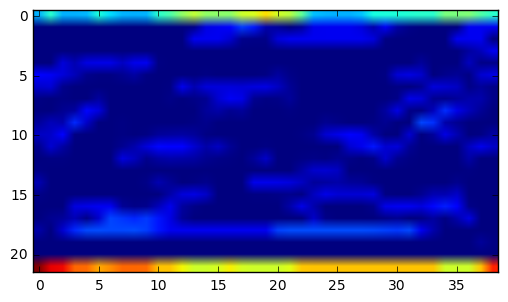

In [16]:
heatmap_transformed = get_heatmaps(img, new_model)
plt.imshow(heatmap_transformed)

In [3]:
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, _obtain_input_shape

def Xception2(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None):
    '''Instantiate the Xception architecture,
    optionally loading weights pre-trained
    on ImageNet. This model is available for TensorFlow only,
    and can only be used with inputs following the TensorFlow
    dimension ordering `(width, height, channels)`.
    You should set `image_dim_ordering="tf"` in your Keras config
    located at ~/.keras/keras.json.

    Note that the default input image size for this model is 299x299.

    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        inputs_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)`.
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 71.
            E.g. `(150, 150, 3)` would be one valid value.

    # Returns
        A Keras model instance.
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
    if K.backend() != 'tensorflow':
        raise Exception('The Xception model is only available with '
                        'the TensorFlow backend.')
    if K.image_dim_ordering() != 'tf':
        warnings.warn('The Xception model is only available for the '
                      'input dimension ordering "tf" '
                      '(width, height, channels). '
                      'However your settings specify the default '
                      'dimension ordering "th" (channels, width, height). '
                      'You should set `image_dim_ordering="tf"` in your Keras '
                      'config located at ~/.keras/keras.json. '
                      'The model being returned right now will expect inputs '
                      'to follow the "tf" dimension ordering.')
        K.set_image_dim_ordering('tf')
        old_dim_ordering = 'th'
    else:
        old_dim_ordering = None

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=299,
                                      min_size=71,
                                      dim_ordering=K.image_dim_ordering(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = Conv2D(32, 3, 3, subsample=(2, 2), bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, 3, 3, bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, 1, 1, subsample=(2, 2),
                      border_mode='same', bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, 3, 3, border_mode='same', bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, 3, 3, border_mode='same', bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same', name='block2_pool')(x)
    x = merge([x, residual], mode='sum')

    residual = Conv2D(256, 1, 1, subsample=(2, 2),
                      border_mode='same', bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, 3, 3, border_mode='same', bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, 3, 3, border_mode='same', bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same', name='block3_pool')(x)
    x = merge([x, residual], mode='sum')

    residual = Conv2D(728, 1, 1, subsample=(2, 2),
                      border_mode='same', bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same', name='block4_pool')(x)
    x = merge([x, residual], mode='sum')

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = merge([x, residual], mode='sum')

    residual = Conv2D(1024, 1, 1, subsample=(2, 2),
                      border_mode='same', bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, 3, 3, border_mode='same', bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same', name='block13_pool')(x)
    x = merge([x, residual], mode='sum')

    x = SeparableConv2D(1536, 3, 3, border_mode='same', bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, 3, 3, border_mode='same', bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)

    x =  AveragePooling2D(pool_size=(10,10), strides=(1,1))(x)
    x = Convolution2D(1000,1,1)(x)
    x = Softmax4D(axis=1,name="softmax")(x)

    # Create model
    model = Model(img_input, x)

    if old_dim_ordering:
        K.set_image_dim_ordering(old_dim_ordering)
    return model

In [4]:
model = Xception2(include_top=False)

In [5]:
def save(i, weights):
    with open("xception/w_" + str(i) + ".p", "wb") as f:
        pickle.dump(weights, f, pickle.HIGHEST_PROTOCOL)
def load(i):
    with open("xception/w_" + str(i) + ".p", "rb") as f:
        weights = pickle.load(f)
    return weights

In [9]:
model.layers[133]

In [16]:
old_model.layers[133]

In [14]:
for i in range(len(old_model.layers)):
    save(i, old_model.layers[i].get_weights())

In [12]:
for i in tq(range(133)):
    a = load(i)
    model.layers[i].set_weights(a)

In [10]:
from keras.applications.imagenet_utils import decode_predictions, _obtain_input_shape
from keras.utils.data_utils import get_file
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'


model = Xception()

ValueError: Dimension 0 in both shapes must be equal, but are 128 and 728 for 'Assign_1' (op: 'Assign') with input shapes: [128], [728].